In [1]:
# standard imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt
import sys
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# custom imports
sys.path.append('../src')
from fetch_range_data import fetch_range_data

# Bitcoin

The purpose of this notebook is to explore methods of bitcoin price forecasting

## Get today's data

In [2]:
# get today's data with custom function
today = dt.date.today() 
first_date = '2015/07/20'
btc = fetch_range_data('BTC/USD', first_date, today)

In [3]:
btc.sort_index()

,unix,low,high,open,close,volume,vol_fiat
date,,,,,,,
2015-07-20,1437350400,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,1437436800,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,1437523200,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,1437609600,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,1437696000,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...,...
2021-09-03,1630627200,48349.66,51064.44,49279.38,50025.00,14577.226219,7.292257e+08
2021-09-04,1630713600,49400.00,50558.75,50025.00,49942.98,7595.488165,3.793413e+08
2021-09-05,1630800000,49500.00,51907.08,49944.89,51789.17,7743.934723,4.010520e+08


## Relabel Data

### Explore special values for BTC

In [4]:
# rename columns of btc dataframe
btc.pop('unix')
my_dict = {'date': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume':'Volume', 'vol_fiat':'Market Cap'}
btc.rename(columns=my_dict, inplace=True)

btc.shape

(2242, 6)

### Convert Index to Datetime

In [5]:
btc.head()

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-12-08,386.69,418.94,394.73,418.94,8264.824572,3.462466e+06
2015-12-07,383.00,397.57,387.53,394.73,7578.140343,2.991319e+06
2015-12-06,375.22,401.01,388.03,387.55,9639.704835,3.735868e+06
2015-12-05,363.97,390.00,363.98,387.99,8731.852301,3.387871e+06
2015-12-04,355.43,364.85,361.89,363.98,5864.705649,2.134636e+06


In [6]:
# # change btc index to Date column datetime objects
if "Date" in btc.columns:
    btc.set_index(pd.to_datetime(btc['Date']),inplace=True)
    btc.pop('Date')

In [7]:
# sort index for ease of comparison
btc.sort_index(inplace=True)
btc

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-09-03,48349.66,51064.44,49279.38,50025.00,14577.226219,7.292257e+08
2021-09-04,49400.00,50558.75,50025.00,49942.98,7595.488165,3.793413e+08
2021-09-05,49500.00,51907.08,49944.89,51789.17,7743.934723,4.010520e+08


In [8]:
btc

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-09-03,48349.66,51064.44,49279.38,50025.00,14577.226219,7.292257e+08
2021-09-04,49400.00,50558.75,50025.00,49942.98,7595.488165,3.793413e+08
2021-09-05,49500.00,51907.08,49944.89,51789.17,7743.934723,4.010520e+08


In [9]:
type(btc.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [10]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

### Resampling

In [11]:
btcM = btc.resample('M').mean()
btcM

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-07-31,283.055000,289.198333,285.987500,286.595833,4931.954199,1.416845e+06
2015-08-31,246.512581,257.395806,253.492903,251.755161,7230.025266,1.765739e+06
2015-09-30,231.936000,236.955000,234.163000,234.365000,6386.535932,1.495726e+06
2015-10-31,261.374839,269.491613,263.724516,266.229032,7850.672554,2.159975e+06
2015-11-30,334.626000,362.877000,347.445000,349.508000,12491.747698,4.548917e+06
...,...,...,...,...,...,...
2021-05-31,44270.166129,48889.056129,47119.199677,46457.782903,29742.506763,1.294962e+09
2021-06-30,34303.263667,37144.137000,35916.499000,35842.765667,19942.838788,7.051311e+08
2021-07-31,33364.951290,35217.746129,34236.297097,34443.391290,11984.850339,4.212497e+08


In [12]:
btcD = btcM.resample('D').mean()
btcD

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-07-31,283.055,289.198333,285.987500,286.595833,4931.954199,1.416845e+06
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-09-26,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-27,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28,NaN,NaN,NaN,NaN,NaN,NaN


# Visualizations

In [13]:
# create xticklabels
xticks_min = []
xticks_maj = []
xlabels_min = []
xlabels_maj = []
year = 0
month = 0

for index in btc.index:
    if year != index.year:
        year = index.year
        xticks_maj.append(index)
        xlabels_maj.append(year)
    if month != index.month:
        month = index.month
        xticks_min.append(index)
        xlabels_min.append(month)


Text(0.5, 1.0, 'Bitcoin Price over Time')

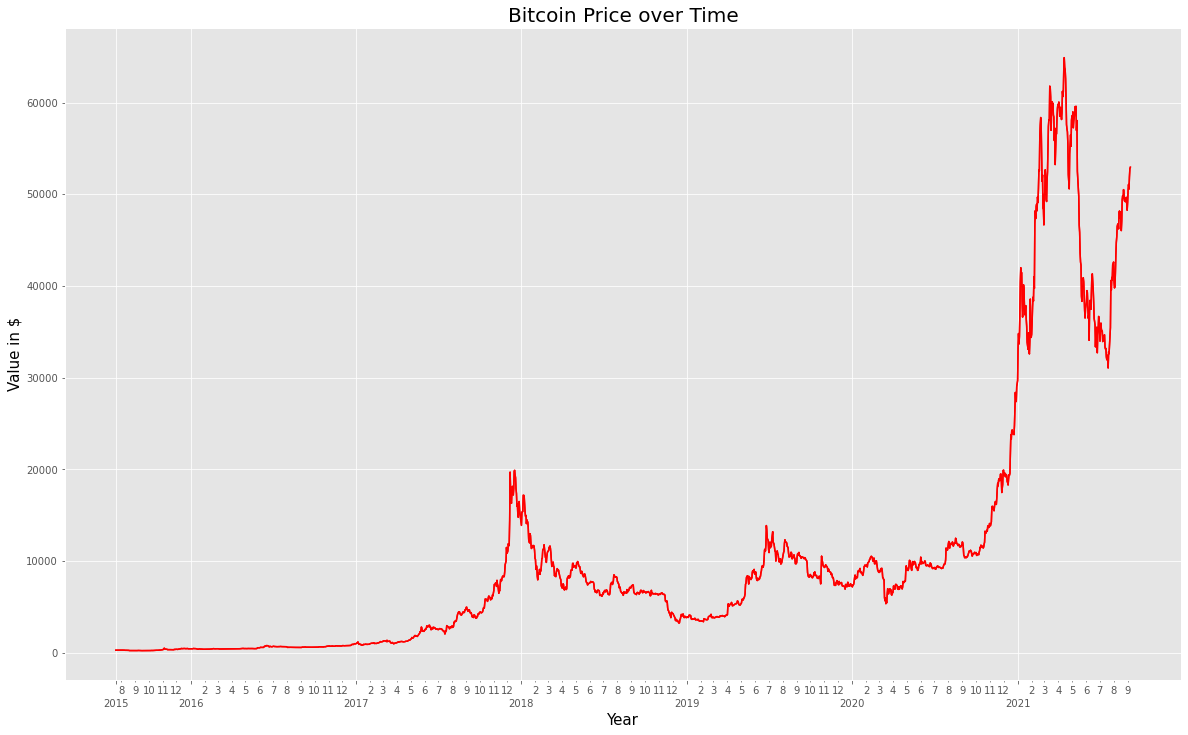

In [14]:
# plot daily high values of data
plt.style.use('ggplot')
figsize = (20,12)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.plot(btc.index, btc.High, c='r', lw=1.5)

ax.set_xticks(xticks_min, minor=True)
ax.set_xticklabels(xlabels_min, minor=True)
ax.set_xticks(xticks_maj, minor=False)
ax.set_xticklabels(xlabels_maj, minor=False)

ax.tick_params(axis='x', which='major', direction='out', rotation=0, pad=15)
ax.tick_params(axis='x', which='minor', direction='out', rotation=0)

ax.set_xlabel("Year", fontsize=15, color='black')
ax.set_ylabel('Value in $', fontsize=15, color='black')
ax.set_title('Bitcoin Price over Time', fontsize=20, color='black')
# plt.savefig('bitcoin_historical_transparent.png', transparent=True, dpi=400)
# plt.savefig('bitcoin_historical.png', transparent=False, dpi=400)

Text(0.5, 1.0, 'Bitcoin Daily Closing Price')

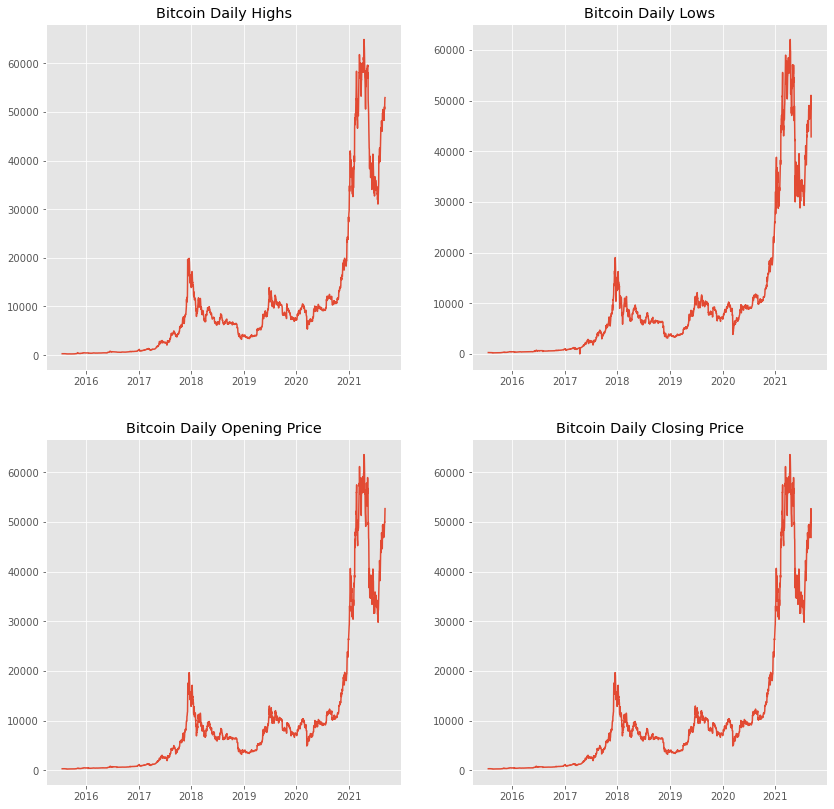

In [15]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening Price')
ax[1,1].set_title('Bitcoin Daily Closing Price')

Text(0.5, 1.0, 'Bitcoin Daily Closing')

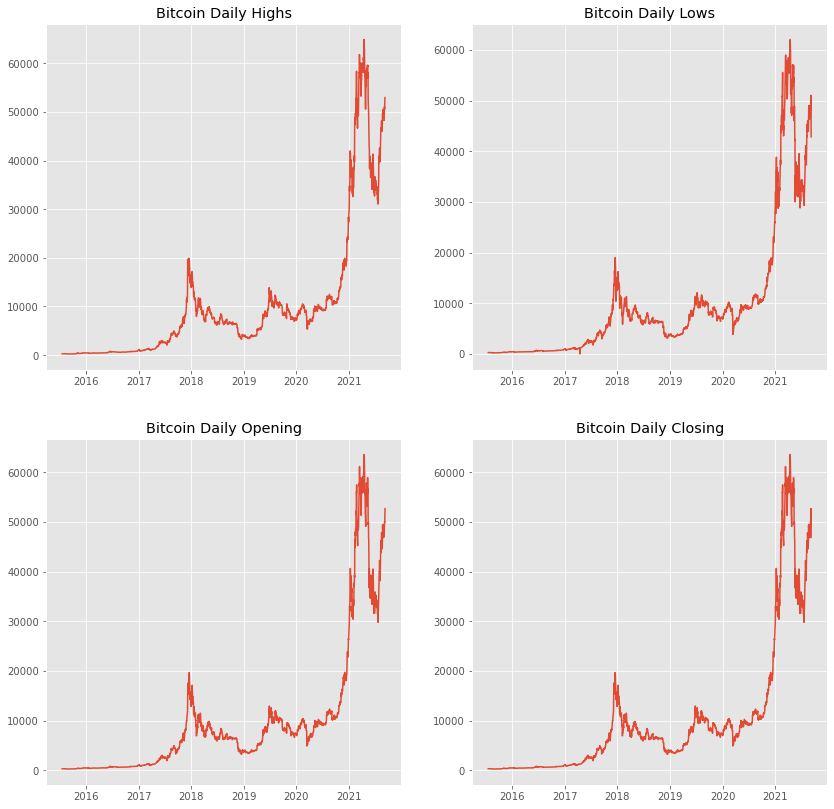

In [16]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening')
ax[1,1].set_title('Bitcoin Daily Closing')

# First Simple Model - Random Walk

In [17]:
end_of_train_index = int(btc.shape[0]*0.8)
end_of_train_index

1793

In [18]:
# separate train and test data
# roughly first 80% of data
train = btc.Close[:end_of_train_index]

# roughly last 20% of data
test = btc.Close[end_of_train_index:]

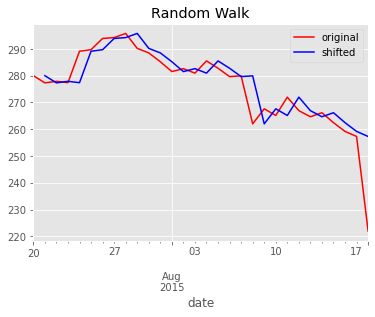

In [19]:
# create "random walk" model, shift values by 1 day
random_walk = train.shift(1)

# create plot of first 30 values of train and random walk
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [20]:
random_walk.dropna(inplace=True)

In [21]:
import sklearn.metrics as metric

In [22]:
train.shape[0]

1793

In [23]:
random_walk[:3]

date
2015-07-21    280.00
2015-07-22    277.32
2015-07-23    277.89
Name: Close, dtype: float64

In [24]:
train[:3]

date
2015-07-20    280.00
2015-07-21    277.32
2015-07-22    277.89
Name: Close, dtype: float64

In [25]:
train.index

DatetimeIndex(['2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29',
               ...
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14', '2020-06-15'],
              dtype='datetime64[ns]', name='date', length=1793, freq=None)

In [26]:
random_walk.index

DatetimeIndex(['2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24',
               '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28',
               '2015-07-29', '2015-07-30',
               ...
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14', '2020-06-15'],
              dtype='datetime64[ns]', name='date', length=1792, freq=None)

In [27]:
metric.mean_squared_error(train[1:], random_walk)

94443.4648112165

In [28]:
metric.mean_squared_log_error(train['2015-07-21':'2015-08-30'], random_walk['2015-07-21':'2015-08-30'])

0.001077400777264864

## ARIMA MODEL

In [29]:
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit

In [30]:
# create timeseriessplit object
data = btc.Close
n = 5
tss = TimeSeriesSplit(n_splits = n)
split_data = tss.split(data)

In [31]:
# save split data for time series cross val
i = 0
tss_train = []
tss_test = []
for j, k in split_data:
    # use globals to save 
    tss_train.append(j)
    tss_test.append(k)
    
tss_train = np.array(tss_train)
tss_test = np.array(tss_test)

<ipython-input-31-a5b0db9321a8>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tss_train = np.array(tss_train)


In [32]:
# define function to print min and max of array/list
def print_info(input_):
    min_value = min(input_) 
    max_value = max(input_)
    
    return f'min: {min_value} max: {max_value}\n'

In [33]:
# iterate through timeseriessplit object and print info
for train_index, test_index in tss.split(data):
    print('Train:', print_info(train_index))
    print('Test:', print_info(test_index))

Train: min: 0 max: 376

Test: min: 377 max: 749

Train: min: 0 max: 749

Test: min: 750 max: 1122

Train: min: 0 max: 1122

Test: min: 1123 max: 1495

Train: min: 0 max: 1495

Test: min: 1496 max: 1868

Train: min: 0 max: 1868

Test: min: 1869 max: 2241



In [34]:
for i in tss_train:
    print(max(i))

376
749
1122
1495
1868


In [35]:
for i in tss_test:
    print(max(i))

749
1122
1495
1868
2241


In [36]:
test_index[1]

1870

### Random Walk with ARIMA

In [37]:
x = btc['Close'].iloc[train_index[0]]
x
# x.append(btc['Close'].iloc[train_index[1]])
# x

280.0

In [38]:
# create endog and exog variables for fitting
endog = train
endog.index = train.index.to_period('D')

In [39]:
# CREATE arima_model object, pass training set and order

# (0,1,0) as the order means 1st order differenced model, essentially a random walk

rw = ARIMA(endog, order=(0,1,0)).fit()

y_hat = rw.predict(typ='levels')
y_hat

date
2015-07-20       0.00
2015-07-21     280.00
2015-07-22     277.32
2015-07-23     277.89
2015-07-24     277.39
               ...   
2020-06-11    9894.04
2020-06-12    9268.16
2020-06-13    9464.17
2020-06-14    9475.00
2020-06-15    9325.00
Freq: D, Length: 1793, dtype: float64

In [40]:
# find squared error and compare to random walk model generated manually
metric.mean_squared_error(train[:], y_hat)

94434.5169780814

### 1st Order ARIMA

In [41]:
# # create endog and exog variables for fitting
# endog = train
# endog.index = endog.index.to_period('D')

In [42]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [43]:
btc

,Low,High,Open,Close,Volume,Market Cap
date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-09-03,48349.66,51064.44,49279.38,50025.00,14577.226219,7.292257e+08
2021-09-04,49400.00,50558.75,50025.00,49942.98,7595.488165,3.793413e+08
2021-09-05,49500.00,51907.08,49944.89,51789.17,7743.934723,4.010520e+08


In [44]:
endog

date
2015-07-20     280.00
2015-07-21     277.32
2015-07-22     277.89
2015-07-23     277.39
2015-07-24     289.12
               ...   
2020-06-11    9268.16
2020-06-12    9464.17
2020-06-13    9475.00
2020-06-14    9325.00
2020-06-15    9432.53
Freq: D, Name: Close, Length: 1793, dtype: float64

In [45]:
# CREATE arima_model object, pass training set and order

# (1,1,0) as the order means 1st order differenced model, with additional lag

ar_1 = ARIMA(train, order=(1,1,0)).fit()

y_hat = ar_1.predict()
y_hat 

date
2015-07-20       0.000000
2015-07-21     279.915541
2015-07-22     277.329363
2015-07-23     277.888009
2015-07-24     277.391747
                 ...     
2020-06-11    9893.639516
2020-06-12    9270.346642
2020-06-13    9463.485198
2020-06-14    9474.962163
2020-06-15    9325.524056
Freq: D, Length: 1793, dtype: float64

In [46]:
y_hat = ar_1.predict(start=test.index[0], end=test.index[-1])

In [47]:
btc.loc['2020-06-05']

Low           9.585440e+03
High          9.855000e+03
Open          9.791960e+03
Close         9.613210e+03
Volume        1.249590e+04
Market Cap    1.201257e+08
Name: 2020-06-05 00:00:00, dtype: float64

In [48]:
y_hat

2020-06-16    9432.154322
2020-06-17    9432.155634
2020-06-18    9432.155629
2020-06-19    9432.155630
2020-06-20    9432.155630
                 ...     
2021-09-03    9432.155630
2021-09-04    9432.155630
2021-09-05    9432.155630
2021-09-06    9432.155630
2021-09-07    9432.155630
Freq: D, Length: 449, dtype: float64

In [49]:
metric.mean_squared_error(train, y_hat[0]*np.ones(len(train)))

37532651.933461234

In [50]:
train

date
2015-07-20     280.00
2015-07-21     277.32
2015-07-22     277.89
2015-07-23     277.39
2015-07-24     289.12
               ...   
2020-06-11    9268.16
2020-06-12    9464.17
2020-06-13    9475.00
2020-06-14    9325.00
2020-06-15    9432.53
Freq: D, Name: Close, Length: 1793, dtype: float64

In [51]:
# CREATE arima_model object, pass training set and order

# try higher order models

ar_2 = ARIMA(train,exog=None, order=(1,2,1)).fit()

y_hat = ar_2.predict(start = test.index[0], end = test.index[10])
y_hat

2020-06-16    9437.316876
2020-06-17    9442.437295
2020-06-18    9447.556631
2020-06-19    9452.675971
2020-06-20    9457.795310
2020-06-21    9462.914650
2020-06-22    9468.033989
2020-06-23    9473.153329
2020-06-24    9478.272668
2020-06-25    9483.392008
2020-06-26    9488.511347
Freq: D, dtype: float64

In [52]:
metric.mean_squared_error(test[0:11], y_hat)

32304.392418723848

In [53]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1793
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -12803.860
Date:                Wed, 08 Sep 2021   AIC                          25613.720
Time:                        22:44:36   BIC                          25630.192
Sample:                    07-20-2015   HQIC                         25619.802
                         - 06-15-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0032      0.009     -0.353      0.724      -0.021       0.015
ma.L1         -0.9999      0.021    -46.881      0.000      -1.042      -0.958
sigma2      9.448e+04   2026.569     46.623      0.000    9.05e+04    9.85e+04
===================================================================================
Ljung-Box (Q):                      123.35   Jarque-Bera (JB):             36534.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             334.47   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# additoinal ARIMIA model
ar_3 = ARIMA(train,exog=None, order=(4,2,3), freq='D').fit()

y_hat = ar_3.predict(typ='levels')
y_hat

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


date
2015-07-20       0.000000
2015-07-21     419.929500
2015-07-22     295.837114
2015-07-23     287.997488
2015-07-24     283.287365
                 ...     
2020-06-11    9962.608249
2020-06-12    9214.936192
2020-06-13    9500.382570
2020-06-14    9479.033591
2020-06-15    9329.533135
Freq: D, Length: 1793, dtype: float64

In [61]:
metric.mean_squared_error(train[:], y_hat)

93393.32107107085

In [66]:
# additoinal ARIMIA model
ar_4 = ARIMA(train, order=(1,1,4), freq='D').fit()

y_hat = ar_4.predict(typ='levels')
metric.mean_squared_error(train[:], y_hat)

94131.82682551965

In [67]:
TimeSeriesSplit(5, btc['Close'], max_train_size=0.8*btc.shape[0])

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass max_train_size=0         280.00
1         277.32
2         277.89
3         277.39
4         289.12
          ...   
2237    50025.00
2238    49942.98
2239    51789.17
2240    52698.81
2241    46894.50
Name: Close, Length: 2242, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TimeSeriesSplit(max_train_size=0         280.00
1         277.32
2         277.89
3         277.39
4         289.12
          ...
2237    50025.00
2238    49942.98
2239    51789.17
2240    52698.81
2241    46894.50
Name: Close, Length: 2242, dtype: float64,
        n_splits=5)

### Make function to make data reshaping easier

In [70]:
# function converts data to array and reshapes for linreg compatibility 
def arr_shape(data):
    data = np.array(data)
    data = data.reshape(-1,1)
    return data

## auto_arima

In [ ]:
arima_model = auto_arima(train,
                         start_p=0,d=0,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

In [ ]:
non_auto_arima = SARIMAX(train,
                        order=(1,1,0),
                        seasonal_order=(1,1,1,96),
                        freq='D').fit()

In [ ]:
non_auto_arima = SARIMAX(train,
                        order=(0,0,0),
                        seasonal_order=(0,1,0,96),
                        freq='D').fit()

In [ ]:
y_pred = non_auto_arima.predict(start='2020-06-05')

In [ ]:
y_pred

In [ ]:
train

In [ ]:
test[0]

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
btc.shape

In [ ]:
btc.Close

In [55]:
close = btc.Close
close.reset_index(drop=True, inplace=True)
close_index = close.index
close = np.squeeze(close.to_numpy())
close_index = np.squeeze(close_index.to_numpy())

In [56]:
close_index[0]

0

In [155]:
# # separate data for linear regression
X_train, X_test, y_train, y_test = train_test_split(close_index, close)

# reshape for linreg
X_train = arr_shape(X_train)
X_test = arr_shape(X_test)
y_train = arr_shape(y_train)
y_test = arr_shape(y_test)


In [156]:
y_train

array([[ 2786.07],
       [ 4214.84],
       [  238.34],
       ...,
       [ 6928.5 ],
       [ 1292.86],
       [50089.15]])

In [157]:
X_train

array([[ 739],
       [ 807],
       [  73],
       ...,
       [ 985],
       [ 592],
       [2105]], dtype=int64)

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [159]:
preds = lr.predict(X_test)

In [160]:
lr.intercept_

array([-5766.96796992])

In [163]:
lr.coef_

array([[13.56697558]])

## Polynomial Features

In [68]:
from sklearn.preprocessing import PolynomialFeatures as pf

In [ ]:
poly = pf(5)
poly.fit_transform((btc.index, btc.Close))

In [72]:
poly?

Type:        PolynomialFeatures
String form: PolynomialFeatures(degree=5)
File:        c:\users\samjd\anaconda3\envs\oy-env\lib\site-packages\sklearn\preprocessing\_data.py
Docstring:  
Generate polynomial and interaction features.

Generate a new feature matrix consisting of all polynomial combinations
of the features with degree less than or equal to the specified degree.
For example, if an input sample is two dimensional and of the form
[a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

Parameters
----------
degree : integer
    The degree of the polynomial features. Default = 2.

interaction_only : boolean, default = False
    If true, only interaction features are produced: features that are
    products of at most ``degree`` *distinct* input features (so not
    ``x[1] ** 2``, ``x[0] * x[2] ** 3``, etc.).

include_bias : boolean
    If True (default), then include a bias column, the feature in which
    all polynomial powers are zero (i.e. a column of ones - a

In [ ]:
poly.powers_